## Changelog:

* v8 Checking code and revising the debug files. Ready for debugging 
* V9 Adding resampling
* V10 Adding tensorboard
* V11 Reducing LSTM layer to 1 in order to have better interpretation in tensorboard
* V12 adding actionId to data in order to debug datasets and step better + fixing the wrong column name for x_prepared + **fixing LABEL WRONG!!!!! ASSIGENMENT **
* V13 removing masking layer and padding with 0 or 9999
* V14 removing two outputs
* V15 returning the masking layer with mask value 99.
    - The result is that without adding masking layer the training accuracy does not increase at all and it remains the same on nearly 50
    - however the validation accuracy remains the same around 50 and does not increase while the validation loss is being increased as allways
* V16 Changing the optimizer to SGD
* V17 Changing the optimizer to rmsprop
* V18 Increasing batch size from 1 to higher and coming back the optimizer to Adam (both roc and accuracy on train was about .9 while the accuracy of validation was 0.5
* V19 Separating validation set from data and feed to the fit function using validation_data param
* V20 Adding another layer of 100 unit
* V21 Joining per stud features
* V22 removing the sampling
* V23 Add two output
* V24 Assumes that we are overfitting so we are going to:
    - Remove additional LSTM layer to simplify the model $\checkmark$
    - Reduce the number of units for LSTM layer $\checkmark$ (saw that finally validation loss starts to deacrease with 20 unit and 200 seq lenght)
    - Reduce the number of features as much as possible (should be done after dinormalizing the binary variables)
    - Reduce the number of seq length $\checkmark$
* V25 Excluding binary variables and some other proportional variables from the standardization step (it seems we are improving!)
* V26 Adding competition validation set for making prediction on un-labeled data
* V27 Bringing resampling back to the game!
* V28 Adding Startify spliting
* V29 Inversing the sequence! (it make more sence to feed the old frames first and then go forward for newer frames)
* V30 A revolutionary update: removing the padding and updating the weights with variable lenght sequences!
* V31 Testing various model architecture and layers with different number of units
    - V31.1 Disabling resampling
* V32 Exclude students with large number of actions e.g. greater than 2000
* V33 Encode categorical features + **USING MinMaxScaler**
* V34 Removing outliers for MinMax feature scaling
* V36 Adding summarization
* V36-Final_presentation Removing comments codes and competition dataset parts and cleanuping project

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing import sequence
from keras import optimizers

from Vis import plot_loss, plot_roc, plot_accuracy
from Preprocessing import Preprocessing, Cols

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler

from matplotlib import pyplot as plt

from pandas import DataFrame, Series
import pandas as pd

import numpy as np

from math import sqrt
from itertools import chain

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# pandas.set_option('max_columns',10)

import os
import glob
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
pre = Preprocessing()
x, y = pre.load_data(time_gap=300)

prepared dataset contains: per_stud_dataset + per_action_dataset_summ


In [3]:
data_with_label = x.reset_index(level=1).drop(["SchoolId", 'MCAS'], axis=1)

In [4]:
labels = DataFrame.from_csv("Dataset/training_label.csv").drop('AveCorrect', axis=1)

data_with_label = data_with_label.join(labels, how="inner")

data_with_label.index = pd.MultiIndex.from_arrays([data_with_label.index, data_with_label.seq_ix])

data_with_label = data_with_label.drop("seq_ix", axis =1)

In [5]:
# Specifying columns that should be normalized
binary_cols = ['correct', 'original', 'hint', 'scaffold', 'bottomHint', 'frIsHelpRequest', 'stlHintUsed', 'frWorkingInSchool',
               'responseIsFillIn', 'responseIsChosen', 'endsWithScaffolding', 'endsWithAutoScaffolding', 'frIsHelpRequestScaffolding', 'timeGreater5Secprev2wrong', 'helpAccessUnder2Sec', 'timeGreater10SecAndNextActionRight', 'timeOver80', 'manywrong']
res_cols = ['RES_BORED', 'RES_CONCENTRATING', 'RES_CONFUSED', 'RES_FRUSTRATED', 'RES_OFFTASK', 'RES_GAMING']
etc_cols = ['isSTEM', 'AveKnow', 'AveCarelessness']

minMaxMean = [prefix + c for prefix in ['min_', 'max_', 'mean_'] for c in res_cols + binary_cols]

should_not_normalize_cols = minMaxMean + etc_cols
# also for 'AveCorrect', 'AveResBored', 'AveResEngcon', 'AveResConf', 'AveResFrust', 'AveResOfftask', 'AveResGaming', 'Ln-1', 'Ln', 
should_not_normalized = data_with_label[should_not_normalize_cols]
should_normalized = data_with_label.drop(should_not_normalize_cols, axis =1)

In [6]:
# Scaling necessary columns
scaler = RobustScaler()
scaled_data = scaler.fit_transform(should_normalized)
scaled_data = DataFrame(scaled_data, index=should_normalized.index, columns=should_normalized.columns)
scaled_data_with_label = scaled_data.join(should_not_normalized)

In [7]:
# Feature selection!
selected_features = ['isSTEM', 'AveKnow', 'AveCarelessness', 'mean_hint', 'mean_timeGreater10SecAndNextActionRight', 'mean_bottomHint', 'mean_correct', 'mean_past8BottomOut','mean_manywrong', 'mean_hintCount','mean_hintTotal']
scaled_data_with_label = scaled_data_with_label[selected_features]

In [8]:
# Building learning datasets/labels and competition preditcion dataset
x = scaled_data_with_label.drop("isSTEM", axis=1)
y = scaled_data_with_label[['isSTEM']].reset_index(level=1, drop=True)
y = y[~y.index.duplicated()]

In [9]:
# Converting X from a 2D dataframe to a 3D list of varibale-lenght sequecens
x = np.array([stud_seq.values for _, stud_seq in x.groupby("ITEST_id")])
y = y.values

In [10]:
# Splitting train/test data 
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.70) # TODO test Startify

In [11]:
# statistics about training and test
print('Number of total unique students in dataset: %d' % len(x))
print('Number of isSTEM==1 students: %d' % len(y[y==1]))
print('Number of isSTEM==0 students: %d' % len(y[y==0]))
print("--------- Train ---------")
print('Number of samples: %d' % len(x_train))
print('label proportion:\n', Series(np.argmax(y_train, axis=1)).value_counts())
print("--------- Test ---------")
print('Number of samples: %d' % len(x_test))
print('label proportion:\n', Series(np.argmax(y_test, axis=1)).value_counts())

Number of total unique students in dataset: 467
Number of isSTEM==1 students: 117
Number of isSTEM==0 students: 350
--------- Train ---------
Number of samples: 326
label proportion:
 0    326
dtype: int64
--------- Test ---------
Number of samples: 141
label proportion:
 0    141
dtype: int64


## Model

In [12]:
# Defining model configs.
batch_size = 1 # as we are using variable-length sequences we have to set batch size to 1 since Keras cannot support batch contains sample with different length
feature_size = x_train[0].shape[1] # num. of features extracted from first training sample
timestep_size = None # here we are using variable-length sequences so there is no fixed timestep size
nb_epoch = 5

In [13]:
# Creating necessary callbacks for early stopping and Tensorboard visualization
tensorboard_callback = TensorBoard(log_dir='./logs_final/v36_LSTM1:50_Dense1_binaryCrossEnt_Adam_Summarized300_scaledRobust_batch10_selectedfeatures_epochs100', histogram_freq=1, batch_size=batch_size, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, verbose=10, mode='min')

In [14]:
# Defining a variable length model!
def create_LSTM_model(feature_size):
    model = Sequential()
    model.add(LSTM(50, input_shape=(None, feature_size)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    return model

In [15]:
# Creating and fitting model by considering that sequence length varies.
model = create_LSTM_model(feature_size)
epoch_histories = []
for i in range(nb_epoch):
    print("epoch: {}".format(i))
    train_history = []
    for seq, label in zip(x_train, y_train):
        loss = model.fit(np.array([seq]), label, epochs=1, batch_size=batch_size)
        train_history.append(loss.history)
    
    val_history = []
    for seq_val, label_val in zip(x_test, y_test):
        val_loss = model.evaluate(np.array([seq_val]),label_val, batch_size=batch_size)
        val_history.append(val_loss)
        print("val_loss for each sample at the end of epoch: {}".format(val_loss))
    epoch_histories.append({"train_history": train_history, "val_history": val_history})

epoch: 0
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.6859 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.7812 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.7184 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.6924 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.6213 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5843 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4844 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.9110 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4627 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5420 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.9735 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.8009 - acc: 0.0000e+00

1/1 [==============================] - 0s - loss: 0.4364 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2423 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3075 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4855 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3073 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4619 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.5505 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3841 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3070 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2827 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4803 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1674 - acc: 1.0000
Epoch 1/1
1/1 [===================

1/1 [==============================] - 0s - loss: 0.1811 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2001 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3550 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2561 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.9997 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.9590 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4949 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3308 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4025 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.2665 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.4187 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3326 - acc: 1.0000
Epoch 1/1
1/1 [=======

1/1 [==============================] - 0s - loss: 0.3576 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4851 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.7354 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3383 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.1912 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2999 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2041 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2020 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.2410 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2144 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.7627 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3275 - acc: 1.0000
Epoch 1/1
1/1 [=======

1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.49825245141983032, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.40368592739105225, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.17398199439048767, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.18446297943592072, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.94436705112457275, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.42978018522262573, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.15889924764633179, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.18426132202148438, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of

1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [1.331544041633606, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.23719893395900726, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [1.1950948238372803, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [1.6379605531692505, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.36338621377944946, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.068231992423534393, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.34704077243804932, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.08883482962846756, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of ep

1/1 [==============================] - 0s - loss: 0.1713 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1252 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1750 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3122 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2130 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.0277 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.7290 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0896 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.2443 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3631 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2337 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1288 - acc: 1.0000
Epoch 1/1
1/1 [===========

1/1 [==============================] - 0s - loss: 0.3641 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2901 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2070 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4883 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.2694 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.9637 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.3040 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2854 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2655 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2442 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.0857 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1821 - acc: 1.0000
Epoch 1/1
1/1 [=======

1/1 [==============================] - 0s - loss: 0.1850 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.5041 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3155 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1910 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1934 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2262 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1705 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2435 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5091 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2442 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2285 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2042 - acc: 1.0000
Epoch 1/1
1/1 [===================

1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.22932128608226776, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.25047868490219116, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.22848972678184509, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.21811617910861969, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [1.2037094831466675, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.10830876231193542, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.25119030475616455, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.15029466152191162, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of 

1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.25156450271606445, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.1876634806394577, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [1.4000284671783447, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.18003171682357788, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.24680963158607483, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.33870601654052734, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.17056991159915924, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [1.6772842407226562, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of ep

1/1 [==============================] - 0s - loss: 0.5058 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.9609 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1441 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1406 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.6041 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1586 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1903 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1593 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1354 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1923 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.6711 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2180 - acc: 1.0000
Epoch 1/1
1/1 [===========

1/1 [==============================] - 0s - loss: 0.1780 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.0115 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2347 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.5743 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1732 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3619 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1883 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2691 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.8327 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2406 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1772 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1886 - acc: 1.0000
Epoch 1/1
1/1 [===========

1/1 [==============================] - 0s - loss: 1.8899 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1780 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.7105 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1788 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2031 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2157 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2428 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.3009 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0945 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5499 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4276 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.9191 - acc: 0.0000e+00
Epoch 1/1
1/1 [=======

1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.58041942119598389, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.33491414785385132, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.22721207141876221, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.19754616916179657, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [1.1699689626693726, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.46813216805458069, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.86619925498962402, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.22173584997653961, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of 

1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.25142139196395874, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.20033732056617737, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [1.4712914228439331, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.56015026569366455, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.2370295524597168, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.22329510748386383, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.57439017295837402, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.263660728931427, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epo

1/1 [==============================] - 0s - loss: 0.3462 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1661 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2259 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3626 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1977 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2801 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3843 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1853 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0904 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5710 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1574 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2184 - acc: 1.0000
Epoch 1/1
1/1 [=======================

1/1 [==============================] - 0s - loss: 0.1528 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1752 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1424 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2163 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.5849 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1229 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0877 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1558 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1792 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1125 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1443 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.3577 - acc: 0.0000e+00
Epoch 1/1
1/1 [===============

1/1 [==============================] - 0s - loss: 1.3294 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1844 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.4243 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2954 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2682 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2454 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2817 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2117 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.8706 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5497 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3281 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4878 - acc: 1.0000
Epoch 1/1
1/1 [===========

1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.36811316013336182, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.25772637128829956, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.61048257350921631, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.33003884553909302, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.78609704971313477, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.55879378318786621, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.66425877809524536, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.16886302828788757, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of

1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [1.266074538230896, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.29923540353775024, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.31901752948760986, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.2054123729467392, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.19845174252986908, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.28507223725318909, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [1.1015492677688599, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.743033766746521, 0.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch

1/1 [==============================] - 0s - loss: 1.2238 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3101 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.8998 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.4688 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.3387 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3262 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2113 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.5205 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3799 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1510 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2470 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2636 - acc: 1.0000
Epoch 1/1
1/1 [===

1/1 [==============================] - 0s - loss: 0.1272 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1217 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1841 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0867 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1003 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1051 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0988 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1469 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1392 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0989 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.0496 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.4985 - acc: 0.0000e+00
Epoch 1/1
1/1 [===============

1/1 [==============================] - 0s - loss: 0.2564 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1689 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2006 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2606 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.0171 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3002 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2312 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1744 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4967 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1150 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1814 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3220 - acc: 1.0000
Epoch 1/1
1/1 [===================

1/1 [==============================] - 0s - loss: 0.7542 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1526 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.8776 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2089 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.2433 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.1393 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1682 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0836 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.0535 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4031 - acc: 1.0000
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.8110 - acc: 0.0000e+00
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1828 - acc: 1.0000
Epoch 1/1
1/1 

1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.13012897968292236, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.14389578998088837, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.48997405171394348, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.15252085030078888, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.3641849160194397, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.20497645437717438, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.15069425106048584, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.080300189554691315, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of

1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.26489657163619995, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.091751314699649811, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.50331908464431763, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.18060770630836487, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.37876203656196594, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.14199799299240112, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.24723178148269653, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end of epoch: [0.14551369845867157, 1.0]
1/1 [==============================] - 0s
val_loss for each sample at the end o

In [16]:
def accumulate_loss_acc():
    for ep_hist in epoch_histories:
        
        tr_hist_list = ep_hist.get("train_history")
        train_acc = np.asscalar(np.mean(np.array([sample_history.get("acc") for sample_history in tr_hist_list]), axis=0))
        train_loss = np.asscalar(np.mean(np.array([sample_history.get("loss") for sample_history in tr_hist_list]), axis=0))
        
        val_hist_list = ep_hist.get("val_history")
        
        val_loss_acc = np.mean(np.array(val_hist_list), axis=0)
        
        yield np.hstack((np.array([train_loss, train_acc]), val_loss_acc))

In [17]:
train_val_loss_acc = np.array([s for s in accumulate_loss_acc()])

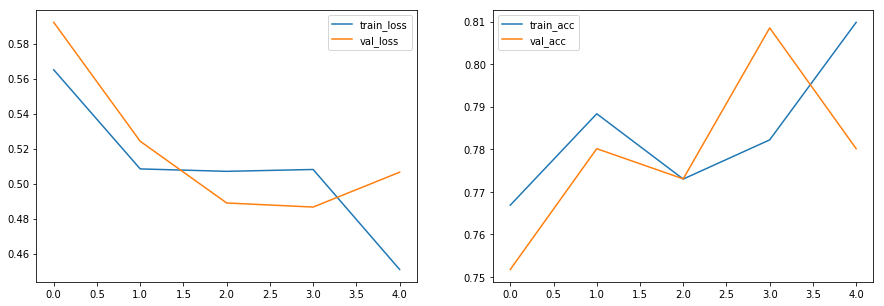

In [18]:
fig, (loss, acc) = plt.subplots(1,2)
fig.set_size_inches(15,5)

loss.plot(np.arange(nb_epoch), train_val_loss_acc[:,0], label="train_loss")
loss.plot(np.arange(nb_epoch), train_val_loss_acc[:,2], label="val_loss")
acc.plot(np.arange(nb_epoch), train_val_loss_acc[:,1], label="train_acc")
acc.plot(np.arange(nb_epoch), train_val_loss_acc[:,3], label="val_acc")
loss.legend();
acc.legend();

In [19]:
# do prediction
predictions = []
for seq_test, label_test in zip(x_test, y_test):
    pred = model.predict(np.array([seq_test]), batch_size=batch_size)
    predictions.append(pred)

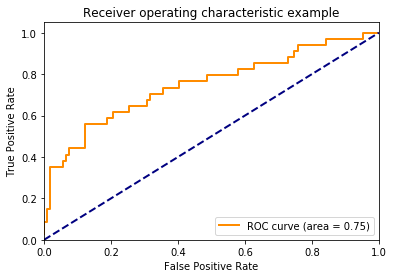

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 12,251
Trainable params: 12,251
Non-trainable params: 0
_________________________________________________________________
None
Test ROC Score: 0.747664
Test RMSE Score: 0.404258
Final Competition Score: 1.343405


In [20]:
# calculating scores
y_true = y_test.flatten()
y_pred = np.array(predictions).flatten()
roc_score = roc_auc_score(y_true, y_pred)
# roc_score = roc_auc_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))

mse_score = mean_squared_error(y_true, y_pred)

#printing and plotting model and score information
# plot_loss(history)
# plot_roc(y_test, y_pred)
plot_roc(y_true, y_pred)
# plot_accuracy(history)

print(model.summary())
print("Test ROC Score: %f" % roc_score)
print("Test RMSE Score: %f" % sqrt(mse_score))
print("Final Competition Score: %f" % (1 - sqrt(mse_score) + roc_score))

### Prediction for competition set

In [21]:
# x_competition2 = np.array([stud_seq.values for _, stud_seq in x_competition.groupby("ITEST_id")])

# # do prediction
# predictions = []
# for seq_test, label_test in zip(x_competition2, y_test):
#     pred = model.predict(np.array([seq_test]), batch_size=batch_size)
#     predictions.append(pred)

In [22]:
# y_pred_competition = y_pred

# result_index = x_competition.reset_index(level=1, drop=True).index.unique()

# argmax_preds = [np.argmax(predicted_label) for predicted_label in y_pred_competition]

# result_df = DataFrame(y_pred_competition, index=pd.Index(result_index, name='ITEST_id'), columns=['isSTEM'])

# final_output = pd.concat([result_df, label_dataset.loc[shared_ids_with_train.values]]).sort_index()
# final_output.to_csv("submition_1_{}.csv".format(theNotebook))
# final_output.isSTEM.value_counts()